# IMDb Rating Predictions: EDA and POC

IMDb, acronym for Internet Movie Database, is a website owned by Amazon.com where users can look for details about movies and TV shows: plot summaries, users reviews, genre, director and cast are just some of the attributes stored on IMDb. 

The goal of this project is to predict the rating of a given movie using properly trained Machine Learning models and evaluate the goodness of the predictions.
The chosen dataset was made available on the Kaggle platform and it contains the top 100 movies between 2003 - 2022. 

Dataset: https://www.kaggle.com/datasets/georgescutelnicu/top-100-popular-movies-from-2003-to-2022-imdb 

In [625]:
import pandas as pd
import numpy as np
import matplotlib as plt


# Data splitting
from sklearn.model_selection import train_test_split

# Creating a pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# GridSearch
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.core.display import display, HTML
import requests
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import scipy.stats as stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import pickle

## EDA

In [626]:
dataset_raw = pd.read_csv('movies.csv')
dataset_raw.head(2)

,Title,Rating,Year,Month,Certificate,Runtime,Directors,Stars,Genre,Filming_location,Budget,Income,Country_of_origin
0,Avatar: The Way of Water,7.8,2022,December,PG-13,192,James Cameron,"Sam Worthington, Zoe Saldana, Sigourney Weaver...","Action, Adventure, Fantasy",New Zealand,"$350,000,000","$2,267,946,983",United States
1,Guillermo del Toro's Pinocchio,7.6,2022,December,PG,117,"Guillermo del Toro, Mark Gustafson","Ewan McGregor, David Bradley, Gregory Mann, Bu...","Animation, Drama, Family",USA,"$35,000,000","$108,967","United States, Mexico, France"


### Dataset

The dataset consists of 13 different features (columns) with 2000 movies (rows). Summary of all the variables in the dataset. 

| Variable | Description | Type | Remove | Processing |
| --- | --- | --- | --- | --- |
| Title | Movie title | str |  |  |
| Rating | Movie rating | float |  |  |
| Year | Release year | int |  |  |
| Month | Release month | str |  | Categorical variable |
| Certificate |  Parental guidence categorisation | str | X |  |
| Runtime | Movie duration in minutes | int |  | Convert to int |
| Directors | Movie directors (can be more than one) | str |  | Replace by IMDb scoring/popularity score |
| Stars | Actors and Actresses (can be more than one) | str |  | Replace by IMDb scoring/popularity score |
| Genre | Type of movie (always more than one) | str |  | One-hot encoding |
| Filming_location | Where the movie was filmed | str | X |  |
| Budget | Amount of money spend on production (different currencies) | str |  | Common currency (USD) and convert to int |
| Income | Movie profit (different currencies) | str |  | Common currency (USD) and convert to int |
| Country_of_origin | Where the movie is produced | str | X |  |

## Primary clean-up of the dataset

1. Removing the 3 columns (not so significant for the analysis)
2. Removing the movie that doesn't have a rating

In [627]:
# Removing unwanted columns
dataset_pruned = dataset_raw.drop(['Certificate', 'Filming_location', 'Country_of_origin'], axis = 1)

# Checking the number of rows
print('-----------------------------')
print(f'Current number of columns: {dataset_pruned.shape[1]}')
print(f'Current number of rows: {dataset_pruned.shape[0]}')

-----------------------------
Current number of columns: 10
Current number of rows: 2000


In [628]:
# Missing values
dataset_pruned.isna().any()

# Which doesn't have a rating
movie_wo_rating = dataset_pruned[dataset_pruned['Rating'].isna()]['Title']
print(f' Movie without rating: {movie_wo_rating}')

# Removing movie from dataset
delete_row = dataset_pruned[dataset_pruned['Title']=='A Man Called Otto'].index
dataset_pruned = dataset_pruned.drop(delete_row)

# Checking the number of rows
print('-----------------------------')
print(f'Current number of columns: {dataset_pruned.shape[1]}')
print(f'Current number of rows: {dataset_pruned.shape[0]}')


 Movie without rating: 85    A Man Called Otto
Name: Title, dtype: object
-----------------------------
Current number of columns: 10
Current number of rows: 1999


## Variable Processing

1. Turning 'Month' into a categorical variable i.e. Jan = 1, Feb = 2 etc.
2. Converting 'Runtime' into type integer 
3. Turning 'Genre' into one-hot encoding 
4. Converting 'Budget' and 'Income' to USD currency

'Directors' and 'Stars' are processed in the next part 

### 1. Month: Converting to categorical vairable 

In [629]:
# Checking how many unique values there are for column Month
month_values = dataset_pruned['Month'].unique()
odd_values_2008 = dataset_pruned['Month'].value_counts()['2008']
odd_values_2014 = dataset_pruned['Month'].value_counts()['2014']

print(f'Unique values: {month_values}')  # Here are some odd values
print(f'Number of times 2008 appears: {odd_values_2008}')
print(f'Number of times 2014 appears: {odd_values_2014}')

Unique values: ['December' 'August' 'November' 'October' 'March' 'September' 'May'
 'April' 'January' 'July' 'June' 'February' '2014' '2008']
Number of times 2008 appears: 1
Number of times 2014 appears: 1


In [630]:
# 1. Drop the 2008 and 2014 containing row
dataset_processed_month = dataset_pruned.drop(dataset_pruned[dataset_pruned['Month'].isin(['2008', '2014'])].index)

# 2. Maping names to integers
month_map = {
    'January': 1, 
    'February': 2, 
    'March': 3, 
    'April': 4, 
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}

# 3. Replacing the names (str) with integers
dataset_processed_month['Month'] = dataset_processed_month['Month'].replace(month_map)
print(dataset_processed_month['Month'])

# 4. Checking the dataset shape
print('-----------------------------')
print(f'Current number of columns: {dataset_processed_month.shape[1]}')
print(f'Current number of rows: {dataset_processed_month.shape[0]}')

0       12
1       12
2        8
3       11
4       12
        ..
1995     6
1996     7
1997    11
1998     2
1999     8
Name: Month, Length: 1997, dtype: int64
-----------------------------
Current number of columns: 10
Current number of rows: 1997


### 2. Runtime: Convering values into integer

In [631]:
# 1. Checking for non-numerical values
dataset_processed_month['Runtime'].unique()  # Movie with unknown duration

# 2. Getting number of movies with uknown runtime
unknown_runtime = dataset_processed_month['Runtime'].value_counts()['Unknown']
print(f'Number of movies with unknown runtime: {unknown_runtime}')

# 3. Removing these movies from the dataset
dataset_processed_runtime = dataset_processed_month.drop(dataset_processed_month[dataset_processed_month['Runtime'].isin(['Unknown'])].index)

# 4. Converting to int values
dataset_processed_runtime['Runtime'] = dataset_processed_runtime['Runtime'].astype(int)

# 5. Checking the dataset shape
print('-----------------------------')
print(f'Current number of columns: {dataset_processed_runtime.shape[1]}')
print(f'Current number of rows: {dataset_processed_runtime.shape[0]}')

Number of movies with unknown runtime: 1
-----------------------------
Current number of columns: 10
Current number of rows: 1996


### 3. Genre: One-Hot Encoding

In [632]:
dataset_processed_genre = dataset_processed_runtime

# 1. Creating a list with all genres mentioned in the dataset
genre_list = []
for genres in dataset_processed_genre['Genre']:
    genre_list.append(genres.split(', '))

# 2. Creating a list with genre categories
unique_g= set()
for genres in genre_list:
    for genre in genres:
        unique_g.add(genre)

unique_genres = list(unique_g)
print(f'''There are {len(unique_genres)}
        possible genres and they are: {unique_genres}''')

There are 20
        possible genres and they are: ['Family', 'Music', 'Musical', 'Mystery', 'Drama', 'Sci-Fi', 'Animation', 'Thriller', 'Biography', 'Crime', 'War', 'Western', 'Action', 'Sport', 'History', 'Romance', 'Adventure', 'Comedy', 'Horror', 'Fantasy']


In [633]:
# 3. Creating a subtable with title as the first column followed by one 
# column per genre
genre_subtable = pd.DataFrame(columns=['Title'] + unique_genres)

# 4. For each movie, assign 1 to those genres it has been assigned 
for i, row in dataset_processed_genre.iterrows():
    new_row = {'Title': row['Title']}
    for genre in unique_genres:
        new_row[genre] = 0
    for genre in row['Genre'].split(', '):
        new_row[genre] = 1
    genre_subtable = genre_subtable.append(new_row, ignore_index=True)

print(genre_subtable.head(2))

                            Title Family Music Musical Mystery Drama Sci-Fi  \
0        Avatar: The Way of Water      0     0       0       0     0      0   
1  Guillermo del Toro's Pinocchio      1     0       0       0     1      0   

  Animation Thriller Biography  ... War Western Action Sport History Romance  \
0         0        0         0  ...   0       0      1     0       0       0   
1         1        0         0  ...   0       0      0     0       0       0   

  Adventure Comedy Horror Fantasy  
0         1      0      0       1  
1         0      0      0       0  

[2 rows x 21 columns]


In [634]:
# 5. Merging the subtable with the main dataset
pivot_table = genre_subtable.melt(id_vars='Title', var_name='Genre')
pivot_table = pivot_table[pivot_table['value'] == 1]
pivot_table = pivot_table.drop(columns=['value'])
pivot_table = pivot_table.pivot_table(index='Title', columns='Genre', aggfunc='size', fill_value=0).reset_index()

# 7. Merge the pivot table with the original DataFrame
dataset_processed_genre = pd.merge(dataset_processed_genre, pivot_table, on='Title', how='left')
dataset_processed_genre.drop(columns=['Genre'], inplace=True)

# 8. Checking the dataset shape
print('-----------------------------')
print(f'Current number of columns: {dataset_processed_genre.shape[1]}')
print(f'Current number of rows: {dataset_processed_genre.shape[0]}')

-----------------------------
Current number of columns: 29
Current number of rows: 1996


### 4. Budget & Income: Turning into USD currency

In [635]:
dataset_processed_finance = dataset_processed_genre

# Checking for how the finance data looks
budget_values = dataset_processed_finance['Budget'].unique()
income_values = dataset_processed_finance['Income'].unique()

#print(f'Budget values: {budget_values}')
#print(f'Income values: {income_values}')

'''There are unconsistencies in how the values are writen, extra 
# spaces etc. Also presence of 'Unknown'''

# 2. Getting number of movies with uknown runtime
unknown_budget_currency = dataset_processed_finance['Budget'].value_counts()['Unknown']
unknown_income_currency = dataset_processed_finance['Income'].value_counts()['Unknown']

missing_budget_values = dataset_processed_finance['Budget'].isnull().sum()
missing_income_values = dataset_processed_finance['Income'].isnull().sum()

print(f'Number of movies with unknown budget: {unknown_budget_currency}')
print(f'Number of movies with empty budget: {missing_budget_values}')
print(f'Number of movies with unknown income: {unknown_income_currency}')
print(f'Number of movies with empty budget: {missing_income_values}')


Number of movies with unknown budget: 303
Number of movies with empty budget: 0
Number of movies with unknown income: 142
Number of movies with empty budget: 0


In [636]:
# 3. Dropping all movies without a budget
dataset_processed_finance = dataset_processed_finance.drop(dataset_processed_finance[dataset_processed_finance['Budget'].isin(['Unknown'])].index)

# 4. Checking the dataset shape
print('-----------------------------')
print(f'Current number of columns (Budget): {dataset_processed_finance.shape[1]}')
print(f'Current number of rows (Budget): {dataset_processed_finance.shape[0]}')


# 5. Dropping all movies without a income
dataset_processed_finance = dataset_processed_finance.drop(dataset_processed_finance[dataset_processed_finance['Income'].isin(['Unknown'])].index)

# 6. Checking the dataset shape
print('-----------------------------')
print(f'Current number of columns (Income): {dataset_processed_finance.shape[1]}')
print(f'Current number of rows (Income): {dataset_processed_finance.shape[0]}')


-----------------------------
Current number of columns (Budget): 29
Current number of rows (Budget): 1693
-----------------------------
Current number of columns (Income): 29
Current number of rows (Income): 1650


In [637]:
# Conversion function (converts currency and to float)
def convert_to_usd(amount):
    amount.replace(' ', '')
    amount.replace('\xa0', '')
    if amount.startswith('$'):
        amount = amount.strip('$').replace(',', '')   # must remove commas
        return float(amount)   # convert str into float
    elif amount.startswith('€'):
        # Exchange rate for EUR to USD
        amount = amount.strip('€').replace(',', '')
        return float(amount) * 1.06 
    elif amount.startswith('¥'):
        # Exchange rate for YEN to USD
        amount = amount.strip('¥').replace(',', '')
        return float(amount) * 0.0075
    elif amount.startswith('₹'):
        # Exchange rate for RPL to USD
        amount = amount.strip('₹').replace(',', '')
        return float(amount) * 0.012 
    elif amount.startswith('SEK'):
        # Exchange rate for SEK to USD
        amount = amount.strip('SEK').replace(',', '')
        return float(amount) * 0.094
    elif amount.startswith('DKK'):
        # Exchange rate for RPL to USD
        amount = amount.strip('DKK').replace(',', '')
        return float(amount) * 0.14
    elif amount.startswith('£'):
        # Exchange rate for RPL to USD
        amount = amount.strip('£').replace(',', '')
        return float(amount) * 1.21  
    else:
        return None

In [638]:
# 7. Applying the conversion function
dataset_processed_finance['Budget'] = dataset_processed_finance['Budget'].apply(convert_to_usd)
dataset_processed_finance['Income'] = dataset_processed_finance['Income'].apply(convert_to_usd)

dataset_processed_finance.info()  # 9 missing values in Budget

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1650 entries, 0 to 1995
Data columns (total 29 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Title      1650 non-null   object 
 1   Rating     1650 non-null   float64
 2   Year       1650 non-null   int64  
 3   Month      1650 non-null   int64  
 4   Runtime    1650 non-null   int64  
 5   Directors  1650 non-null   object 
 6   Stars      1650 non-null   object 
 7   Budget     1641 non-null   float64
 8   Income     1650 non-null   float64
 9   Action     1650 non-null   int64  
 10  Adventure  1650 non-null   int64  
 11  Animation  1650 non-null   int64  
 12  Biography  1650 non-null   int64  
 13  Comedy     1650 non-null   int64  
 14  Crime      1650 non-null   int64  
 15  Drama      1650 non-null   int64  
 16  Family     1650 non-null   int64  
 17  Fantasy    1650 non-null   int64  
 18  History    1650 non-null   int64  
 19  Horror     1650 non-null   int64  
 20  Music   

In [639]:
# 8. Removing 9 titles with empty budget values 
dataset_processed_finance = dataset_processed_finance.dropna(axis=0, subset=['Budget'])

# 9. Checking the dataset shape
print('-----------------------------')
print(f'Current number of columns: {dataset_processed_finance.shape[1]}')
print(f'Current number of rows: {dataset_processed_finance.shape[0]}')


-----------------------------
Current number of columns: 29
Current number of rows: 1641


<AxesSubplot: >

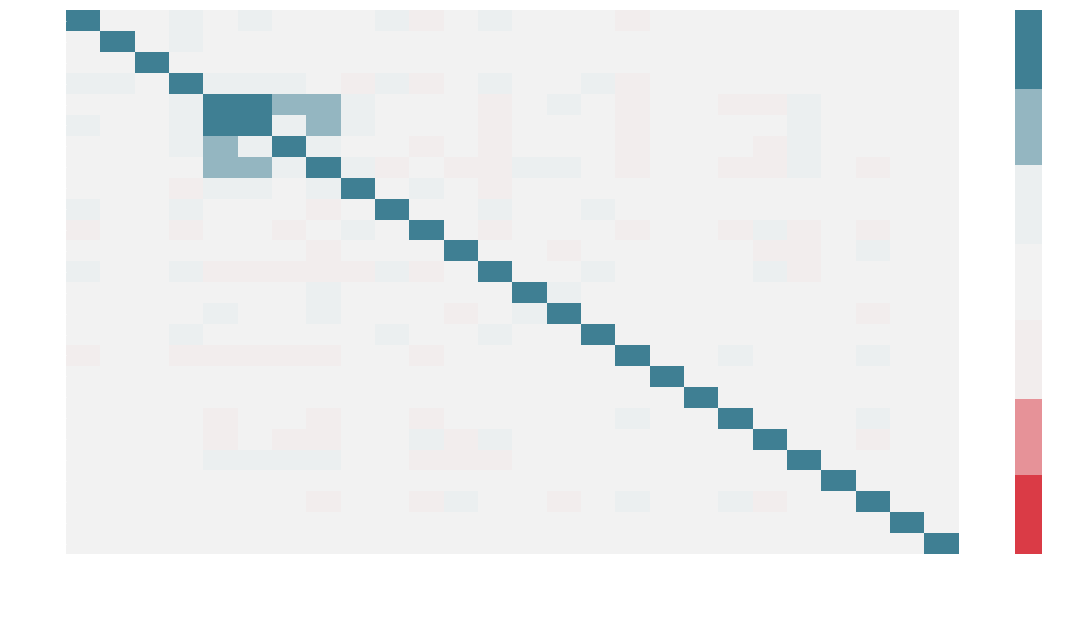

In [642]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(dataset_processed_finance.drop(['Directors', 'Stars'], axis=1).corr(), ax=ax, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(10, 220, sep=80, n=7))

In [640]:
dataset_processed_1 = dataset_processed_finance

## Processing 'Directors' and 'Stars'

This part needs more work and additional database. I think these columns will have an effect on the scoring of the movie, but they are strings right now. I think we should:
1. Directors column should only contain the first director and ignore all other
2. Stars column should be split into 'Lead' and 'Supporting' where the first actor is added to the lead and the second to the supporting
3. Replace the directors and actors with their imdb score of how good they are or some popularity score

In [ ]:
dataset_processed_1['Lead'] = dataset_processed_1['Stars'].fillna('').str.split(',', expand=True)[0]
dataset_processed_1['Supporting'] = dataset_processed_1['Stars'].fillna('').str.split(',', expand=True)[1]
dataset_processed_1.drop(columns=['Stars'], inplace=True)

<AxesSubplot: >

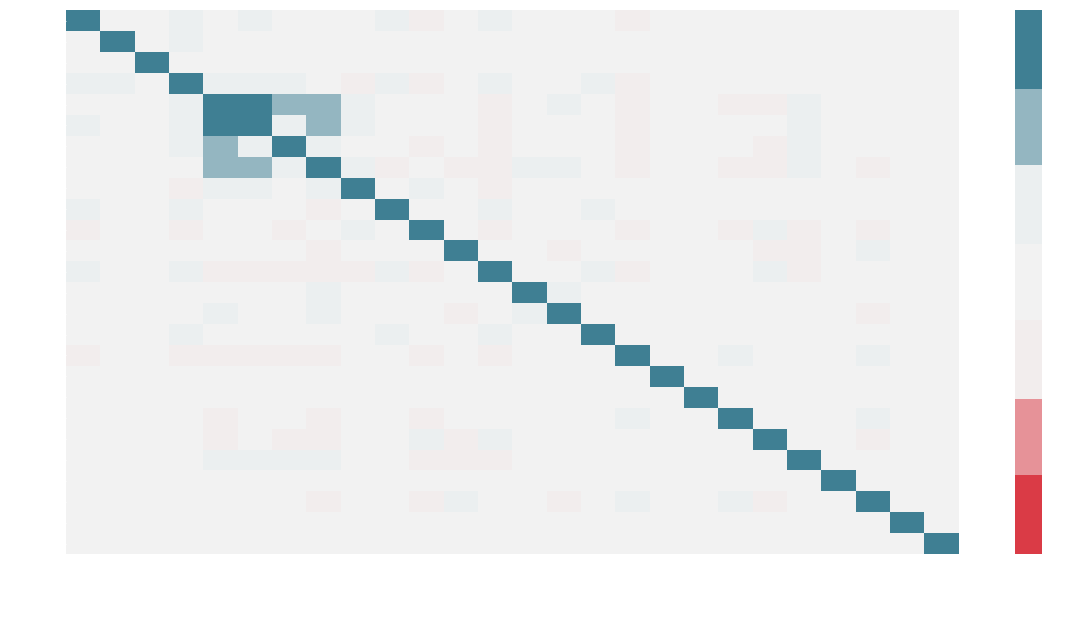

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(dataset_w_finances.drop(['Directors', 'Lead', 'Supporting'], axis=1).corr(), ax=ax, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(10, 220, sep=80, n=7))

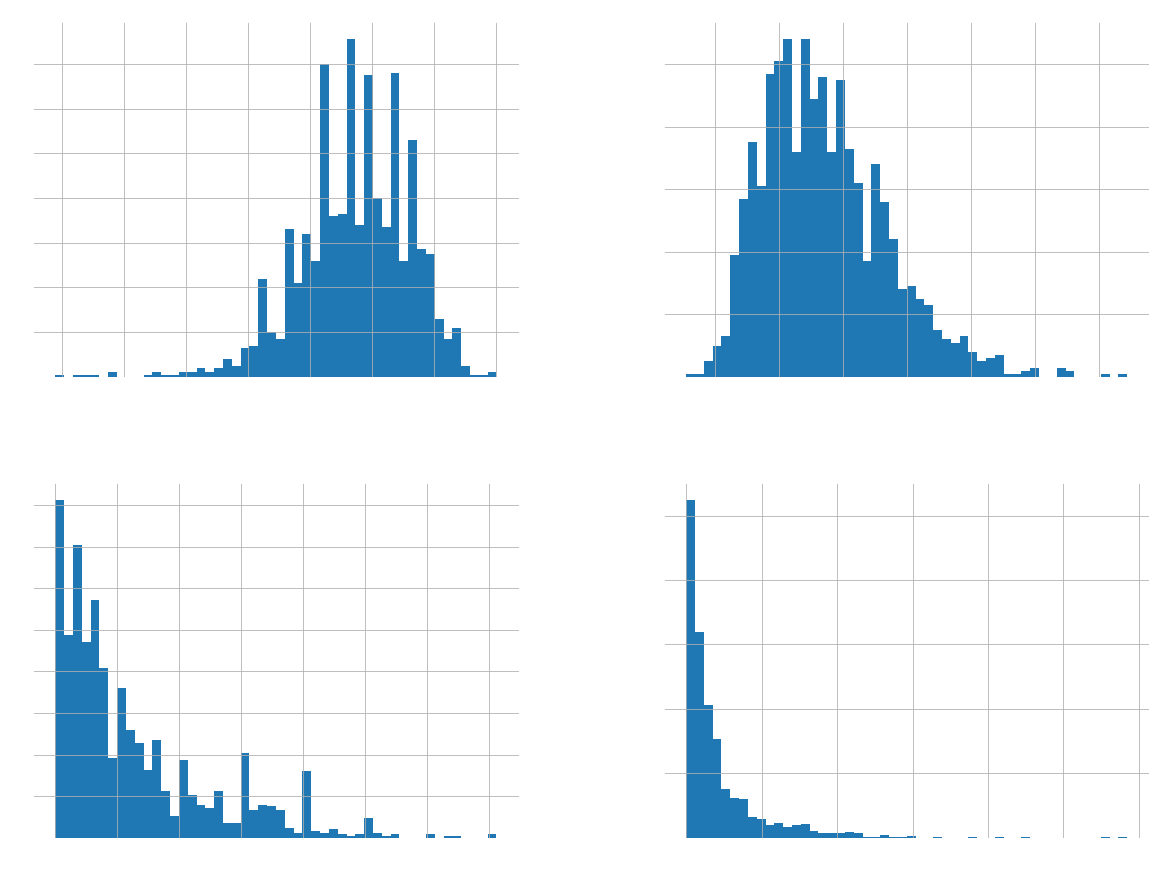

In [ ]:
params = {'ytick.color' : 'w',
          'xtick.color' : 'w',
          'axes.labelcolor' : 'w',
          'axes.edgecolor' : 'w', 
          'text.color': 'w'}
plt.rcParams.update(params)

dataset_w_finances[['Rating', 'Runtime', 'Budget', 'Income']].hist(bins=50, figsize=(20, 15))
plt.show()

In [ ]:
dataset_w_finances = dataset_w_finances.drop(['Directors', 'Lead', 'Supporting', 'Country_of_origin'], axis=1)
print(dataset_w_finances.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1636 entries, 0 to 1635
Data columns (total 27 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Title      1636 non-null   object 
 1   Rating     1636 non-null   float64
 2   Year       1636 non-null   int64  
 3   Month      1636 non-null   int64  
 4   Runtime    1636 non-null   int64  
 5   Budget     1636 non-null   float64
 6   Income     1636 non-null   float64
 7   Action     1636 non-null   int64  
 8   Adventure  1636 non-null   int64  
 9   Animation  1636 non-null   int64  
 10  Biography  1636 non-null   int64  
 11  Comedy     1636 non-null   int64  
 12  Crime      1636 non-null   int64  
 13  Drama      1636 non-null   int64  
 14  Family     1636 non-null   int64  
 15  Fantasy    1636 non-null   int64  
 16  History    1636 non-null   int64  
 17  Horror     1636 non-null   int64  
 18  Music      1636 non-null   int64  
 19  Musical    1636 non-null   int64  
 20  Mystery 

In [ ]:
import numpy as np

criteria = [dataset_w_finances['Rating'].between(0, 3), dataset_w_finances['Rating'].between(4, 6), dataset_w_finances['Rating'].between(7, 8), dataset_w_finances['Rating'].between(9, 10)]
values = [0, 1, 2, 3]

dataset_w_finances['Target'] = np.select(criteria, values, 0)
dataset_w_finances.tail()
dataset_w_finances = dataset_w_finances.drop('Rating',axis=1)

In [ ]:
X, y = dataset_w_finances.iloc[:,1:], dataset_w_finances['Target']
cols = list(X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=20)

In [ ]:
y_pred_mean = [y_train.mean()] * len(y_test)

print("Baseline score RMSE: ",'{0:0.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred_mean))))

Baseline score RMSE:  0.89


In [ ]:
KNN = KNeighborsClassifier()
Extra = ExtraTreesClassifier()
GD = GradientBoostingClassifier()
rf = RandomForestClassifier(n_estimators=100)

In [ ]:
GD.fit(X_train, y_train)
gd = GD.score(X_test, y_test)
print(f'GradientBoostingClassifier: :',gd*100)

GradientBoostingClassifier: : 100.0


In [ ]:
rf.fit(X_train, y_train)
RF = rf.score(X_test, y_test)
print(f'Random forest:', RF*100)

Random forest: 100.0


In [ ]:
Extra.fit(X_train, y_train)
extra = Extra.score(X_test, y_test)
print(f'Extratrees: ',extra*100)

Extratrees:  100.0


In [ ]:
len(dataset_w_finances)

1636

Scores are bad, we must add the actors and directors. Assigning IDs to actors (0-1000) and dictors (2000-3000). 

In [ ]:
from sklearn import metrics

print(metrics.classification_report(y_test, y_pred))

NameError: name 'y_pred' is not defined